<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
from IPython.display import clear_output
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)
import warnings
warnings.filterwarnings('ignore')

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
# если нормализацию не делать картинки на выходзагрузчика данных получаются тусклыми

def get_dataloader(data_dir: str, image_size: int, batch_size: int):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    # TODO: resize images, convert them to tensors and build dataloader
    data = ImageFolder(data_dir, transform=tt.Compose([
        # чтобы использовать ImageFolder пришлось изменить структуру faces_dataset_small, теперь один класс 1
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.ToTensor(),
        tt.Normalize(*stats)
    ]))
    train_dataloader = DataLoader(data, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return train_dataloader

In [4]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
DATA_DIR = "../data/faces_dataset_small"
#TODO: build dataloader and transfer it to device
data_dl = get_dataloader(data_dir=DATA_DIR, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

In [5]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
train_dl = DeviceDataLoader(data_dl, device)

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    plt.show()

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

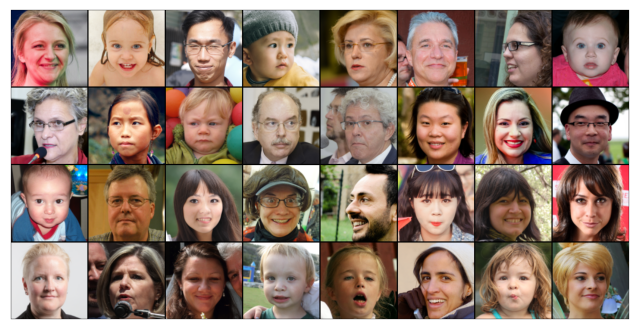

In [8]:
show_batch(data_dl)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # input is ``(3) x 128 x 128``
        self.enc_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
            )
            # state size. ``(64) x 64 x 64``
        self.enc_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
            )
            # state size. ``(128) x 32 x 32``
        self.enc_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
            )
            # state size. ``(256) x 16 x 16``
        self.enc_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
            )
            # state size. ``(512) x 8 x 8``
        self.enc_5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
            )
            # state size. ``(1024) x 4 x 4``
        self.enc_6 = nn.Sequential(
            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
            )
            # state size. ``(1) x 1 x 1``


    def forward(self, x):
        x = self.enc_1(x)
        x = self.enc_2(x)
        x = self.enc_3(x)
        x = self.enc_4(x)
        x = self.enc_5(x)
        x = self.enc_6(x)
        return x

In [10]:
discriminator = Discriminator()

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # добавил в начале генератора Unflatten, чтобы не менять код при использовании разных 
        # генераторов

        self.unflat = nn.Unflatten(1, (1024,1, 1))
        # in: latent_size x 1 x 1
        self.ctrs_1 = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True)
            )
        # out: 1024 x 4 x 4
        self.ctrs_2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
            )
        # out: 512 x 8 x 8
    
        self.ctrs_3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
            )
        # out: 256 x 16 x 16
    
        self.ctrs_4 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
            )
        # out: 128 x 32 x 32
    
        self.ctrs_5 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
            )
        # out: 64 x 64 x 64
    
        self.end = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            )
        # out: 3 x 128 x 128

    def forward(self, x):
        x = self.unflat(x)
        x = self.ctrs_1(x)
        x = self.ctrs_2(x)
        x = self.ctrs_3(x)
        x = self.ctrs_4(x)
        x = self.ctrs_5(x)
        x = self.end(x)
        return x

In [12]:
# latent_size = 1024 # choose latent size
# generator = Generator()

In [13]:
# создадим генератор на основе SegNet
class Generator_SegNet(nn.Module):
    def __init__(self):
        super(Generator_SegNet, self).__init__()

        self.unflat = nn.Unflatten(1, (3,128, 128))

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        ) # 64-128-128
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 64-64-64
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(), # 128-64-64
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        ) # 128-64-64  self.pool > 128-32-32
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(), # 256-32-32
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        ) # 256-32-32  self.pool >  256-16-16
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(), # 512-16-16
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )  # 512-16-16  self.pool >  512-8-8

        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(), # 1024-8-8
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024)
        )  # 1024-8-8  self.pool >  1024-4-4
        
        
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024)
        ) # 1024-4-4
        
        # decoder (upsampling)
        self.upsample = nn.MaxUnpool2d(2, stride=2)  # 1024-8-8

        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(), # 1024-8-8
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(), # 512-8-8
            nn.BatchNorm2d(512)
        )  # 512-8-8  self.upsample  >  512-16-16
        
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(), # 512-16-16
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(), # 256-16-16
            nn.BatchNorm2d(256)
        )  # 256-16-16  self.upsample  >  256-32-32

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),  # 256-32-32
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )  # 128-32-32   self.upsample  >  128-64-64

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),  # 128-64-64
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(), 
            nn.BatchNorm2d(64)
        ) # 64-64-64   self.upsample  >  64-128-128
        # 128 -> 256
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),  # 64-128-128
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding=1), # 3-128-128
            nn.Tanh()
        )

    def forward(self, x):
        x = self.unflat(x)
        # encoder
        e0, id0 = self.pool(self.enc_conv0(x))
        e1, id1 = self.pool(self.enc_conv1(e0))
        e2, id2 = self.pool(self.enc_conv2(e1))
        e3, id3 = self.pool(self.enc_conv3(e2))
        e4, id4 = self.pool(self.enc_conv4(e3))

        # bottleneck
        b = self.bottleneck_conv(e4)

        # decoder
        d0 = self.dec_conv0(self.upsample(b, id4))
        d1 = self.dec_conv1(self.upsample(d0, id3))
        d2 = self.dec_conv2(self.upsample(d1, id2))
        d3 = self.dec_conv3(self.upsample(d2, id1))
        d4 = self.dec_conv4(self.upsample(d3, id0))
        return d4

Generator_SegNet не порадовала результатами, даже после 400 эпох качество генерируемых изображений низкое

In [14]:
latent_size = 49152 # choose latent size
generator = Generator_SegNet()

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [15]:
lr = 0.0005

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [16]:
# создаем функцию обучения
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # создадим списки для ошибок и скора
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # зададим алгоритм оптимизации
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # обучение discriminator
            # обнуление discriminator градиента
            optimizer["discriminator"].zero_grad()

            # подаем реальные изображения на discriminator
            real_images.to(device)
            real_preds = model["discriminator"](real_images)
            # некоторым реальным изображениям присвоим класс 0
            real_targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.95, 1.0).to(device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # создание изображений генератором
            latent = torch.randn(BATCH_SIZE, latent_size, device=device)
            fake_images = model["generator"](latent)

            # подаем полученые от генератора изображения на discriminator
            # в таргет генерируемых изображений добавим немного ошибочных значений
            fake_targets = torch.FloatTensor(fake_images.size(0), 1).uniform_(0.0, 0.05).to(device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # обновляем веса на discriminator
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # обучаем generator
            # обнуление градиента generator
            optimizer["generator"].zero_grad()
            
            # создаем изображение генератором
            latent = torch.randn(BATCH_SIZE, latent_size, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(BATCH_SIZE, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # обновим веса генератора
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # запишем ошибки и скоры
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # покажем сгенерированные изображения
        clear_output(wait=True)
        fake_images_to_show = fake_images[:24].detach().cpu()
        show_images(fake_images_to_show)
        
        # покажем лоссы и скоры последней эпохи
        print(f"Epoch [{epoch +1}/{epochs}], loss_g: {round(losses_g[-1], 4)}",
        f"loss_d: {round(losses_d[-1], 4)}, real_score: {round(real_scores[-1], 4)}",
        f"fake_score: {round(fake_scores[-1], 4)}", sep=", ")

    
    return losses_g, losses_d, real_scores, fake_scores

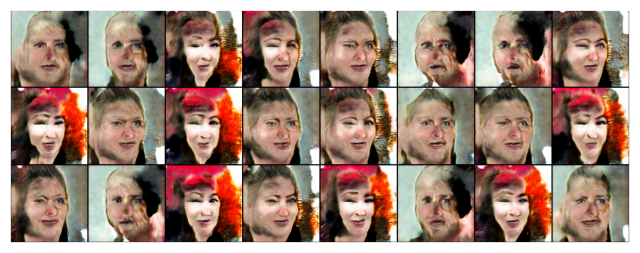

Epoch [50/50], loss_g: 6.7053, loss_d: 0.4692, real_score: 0.904, fake_score: 0.0945


In [17]:
# обучим модели
history = fit(model, criterion, epochs=50, lr=lr)

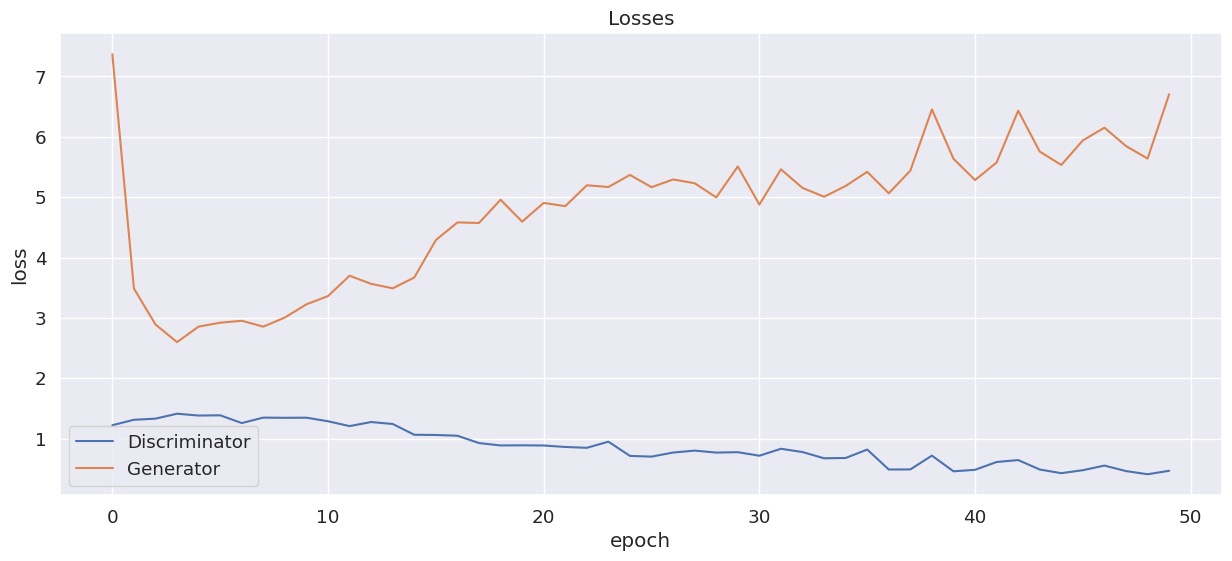

In [18]:
# Построим графики лоссов
plt.figure(figsize=(15, 6))
plt.plot(history[1], '-')
plt.plot(history[0], '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

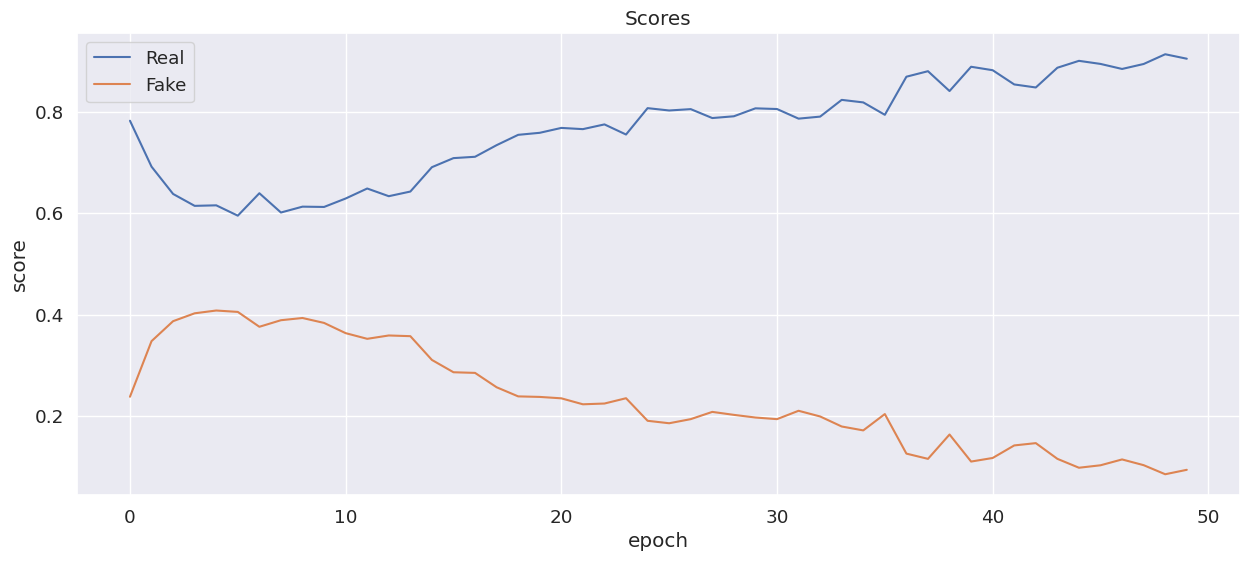

In [19]:
plt.figure(figsize=(15, 6))

plt.plot(history[2], '-')
plt.plot(history[3], '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

Лосс Дискриминатора вначале растет, но после 10 эпохи постоянно снижается. Лосс Генератора вначале резко снижается, но после 10 эпохи постоянно растет. Можно сделать вывод, что к 10 эпохе и генератор и дискриминатор уже более менее обучились (если не добавлять ошибки в таргеты реальных и генерируемых изображений, то лосс дискриминатора стремится к 0)

На графиках скора, также видно, что после 10 эпохи качество дискриминарора растет быстрее относительно генератора, и дискриминатора все лучше отличает реальные изображения от сгенерированых.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [20]:
n_images = 24
# сгененируем изображения
fixed_latent = torch.randn(n_images, latent_size, device=device)
fake_images = model["generator"](fixed_latent)
fake_images = torch.Tensor.cpu(fake_images)

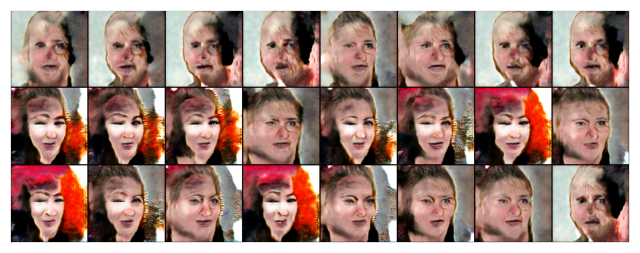

In [21]:
# выведем сгенерированное изображение с помощью функции написаной в начале
show_images(fake_images)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [36]:
len_im_dataset = 3143

In [37]:
fake_images = torch.randn(len_im_dataset, latent_size, device=device)

In [44]:
# генерируем фейковые изображения
fake_images_all = torch.FloatTensor()
model["generator"].eval()
start = 0
for i in range(50, len_im_dataset +1, 50):
    end = i
    with torch.no_grad():
        fake_image = model["generator"](fake_images[start:end]).cpu().detach()
    fake_images_all = torch.cat((fake_images_all, fake_image.cpu()), 0)
    start = i
with torch.no_grad():
    fake_image = model["generator"](fake_images[3100:3143]).cpu().detach()
fake_images_all = torch.cat((fake_images_all, fake_image.cpu()), 0)

In [45]:
# проверяем размер полученного тензора
fake_images_all.size()

torch.Size([3143, 3, 128, 128])

In [46]:
# переводим реальные изображения на cpu
real_images_all = torch.FloatTensor()
for real_images, _ in tqdm(train_dl):
    real_images_all = torch.cat((real_images_all, real_images.cpu()), 0)

  0%|          | 0/99 [00:00<?, ?it/s]

In [47]:
# проверяем размер тензора с реальными изображениями
real_images_all.size()

torch.Size([3143, 3, 128, 128])

In [48]:
# объединяем реальные и сгенерированные изображения
real_and_fake_images = torch.cat((real_images_all.to('cpu'), fake_images_all.to('cpu')))

In [49]:
# проверяем размерность
real_and_fake_images.size()

torch.Size([6286, 3, 128, 128])

In [50]:
len_all_image = real_and_fake_images.shape[0]

In [51]:
real_and_fake_images = real_and_fake_images.reshape(len_all_image,-1) #создадим плоский вектор
real_and_fake_images.size()

torch.Size([6286, 49152])

In [52]:
# переведем в numpy
real_and_fake_images = real_and_fake_images.numpy()

### Подготовка фейковых изображений и их меток класса

In [53]:
# метки класса 0 для сгенерированных изображений
fake_class = np.zeros((len_im_dataset, 1))
# метки класса 1 для реальных
real_class = np.ones((len_im_dataset, 1))

In [54]:
real_and_fake_class = np.concatenate((real_class, fake_class), axis=0)

In [57]:
# Обучение KNN-классификатора. Требуемое время около 3-х часов в GoogleColab.

clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
loo = LeaveOneOut()
accuracy_list = []
classes_list = []
y_pred_list = []
for train_index, test_index in tqdm(loo.split(real_and_fake_images)):
    X_train, X_test = real_and_fake_images[train_index], real_and_fake_images[test_index]
    y_train, y_test = real_and_fake_class[train_index], real_and_fake_class[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_list.append(y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)
    classes_list.append(y_test)

0it [00:00, ?it/s]

In [63]:
import pandas as pd
# Точность предсказаний по классам
df = pd.DataFrame()
df['accuracy'] = accuracy_list
df['accuracy'] = df['accuracy'].astype('int')
df['classes'] = classes_list
df['classes'] = df['classes'].astype('int')
df.pivot_table(values='accuracy', index='classes', aggfunc='mean')

,accuracy
classes,
0,1.00000
1,0.98441


In [62]:
# Общая точность 1NN
round(df['accuracy'].mean(),2)

0.99

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

100% сгенерированых изображений распознаются как фейк, 2% реальных распознаются как фейк. Плохое качество генератора

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [55]:
real_and_fake_images_tsne = TSNE(n_components=2, n_jobs=-1).fit_transform(real_and_fake_images)

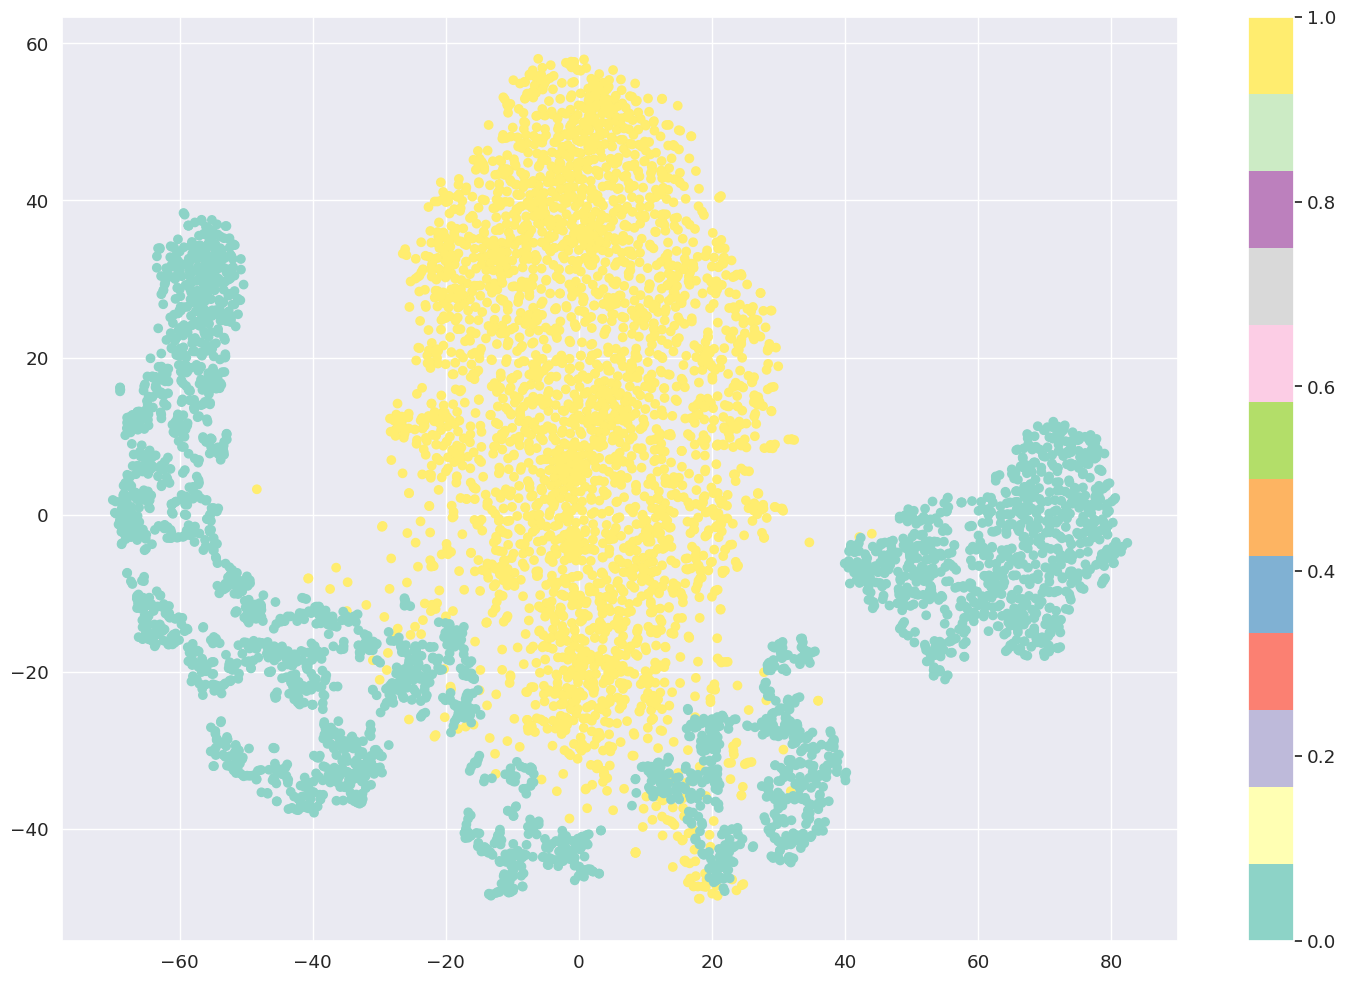

In [56]:
plt.figure(figsize=(18, 12))
plt.scatter(real_and_fake_images_tsne[:, 0], real_and_fake_images_tsne[:, 1], c=real_and_fake_class, cmap='Set3')
plt.colorbar()

Прокомментируйте получившийся результат:

In [58]:
Сгенерированые изображения находятся по сторонам от реальных, возможно при большем количестве эпох они бы сошлись  
в центре с реальными изображениями (400 эпох обучения этого не долбились), есть небольшие зоны пересечения  
сгенерированых и реальных изображений, часть изображений генератор создает как реальные.

SyntaxError: invalid syntax (129556060.py, line 1)